In [24]:
import os
import glob
import math

import librosa
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
INPUT_SR = 44100
OUTPUT_SR = 22050
DUR = 1

In [25]:
labels = os.listdir('dataset/')
filenames = np.array(glob.glob('dataset/*/*.wav'))
num_samples = len(filenames)
np.random.shuffle(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(glob.glob('./dataset/'+labels[0]+'/*')))
print('Example file tensor:', filenames[0])


Number of total examples: 601
Number of examples per label: 200
Example file tensor: dataset\ambulance\sound_22.wav


In [26]:
tmp = math.floor(num_samples*0.8)
dtmp = math.floor(num_samples*0.1)
train_files = filenames[:tmp]
val_files = filenames[tmp: tmp + dtmp]
num_test_files = num_samples - (len(train_files) + len(val_files))
test_files = filenames[-num_test_files:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 480
Validation set size 60
Test set size 61


In [27]:
def decode_audio(audio_binary):
  audio, rate = tf.audio.decode_wav(audio_binary, desired_channels = 1, desired_samples= INPUT_SR * DUR)
  audio = tfio.audio.resample(audio, INPUT_SR, OUTPUT_SR)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
#   parts = file_path.split(os.sep)
#   return parts[-2]
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

# decode_audio(filenames[0])
# get_label(filenames[0])

In [28]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


tf.Tensor(
[ 0.          0.          0.         ... -0.03655706 -0.04704184
 -0.05519014], shape=(22050,), dtype=float32)
tf.Tensor(
[-1.8434196e-06  2.5904224e-06 -3.6936024e-06 ...  6.1066888e-02
  5.8925331e-02  3.2898944e-02], shape=(22050,), dtype=float32)
tf.Tensor(
[-4.0171199e-07 -1.1422549e-07  1.2742009e-07 ... -1.3818434e-01
 -2.1831712e-01 -2.1621768e-01], shape=(22050,), dtype=float32)
tf.Tensor(
[ 3.7271519e-07 -7.0936727e-07  9.0431143e-07 ... -3.5994932e-02
 -3.5752207e-02 -4.0130801e-02], shape=(22050,), dtype=float32)
tf.Tensor(
[-2.0227048e-07  4.3713264e-08 -1.3787320e-07 ...  3.1332236e-02
  3.3968389e-02  3.1220453e-02], shape=(22050,), dtype=float32)
tf.Tensor(
[-1.2447414e-07  1.4658684e-07 -2.0669106e-07 ... -3.5786033e-02
 -4.5161575e-02 -5.3454816e-02], shape=(22050,), dtype=float32)
tf.Tensor(
[-2.7635381e-06  3.2991334e-06 -4.0185278e-06 ...  2.1064094e-01
  2.6421016e-01  2.7942824e-01], shape=(22050,), dtype=float32)
tf.Tensor(
[ 3.7625139e-07 -5.4986106e

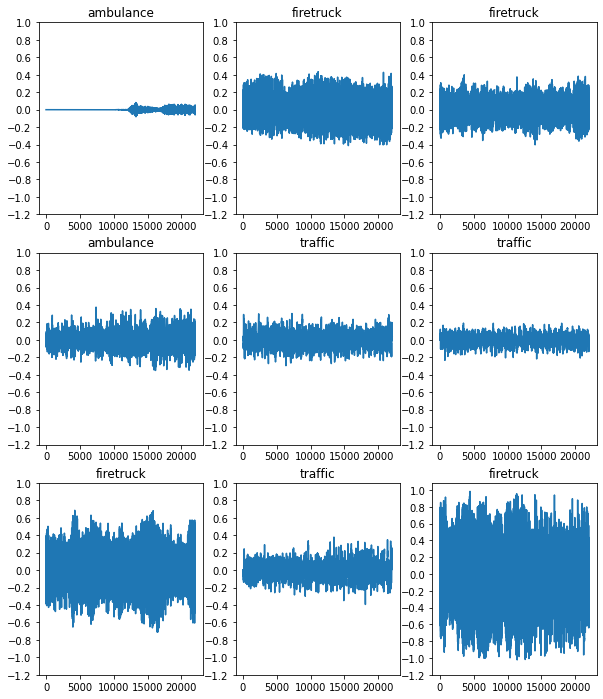

In [29]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  print(audio)
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [30]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([OUTPUT_SR*DUR] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == labels)
  return spectrogram, label_id

<ipython-input-31-85a54aec5494>:7: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram)
<ipython-input-31-85a54aec5494>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


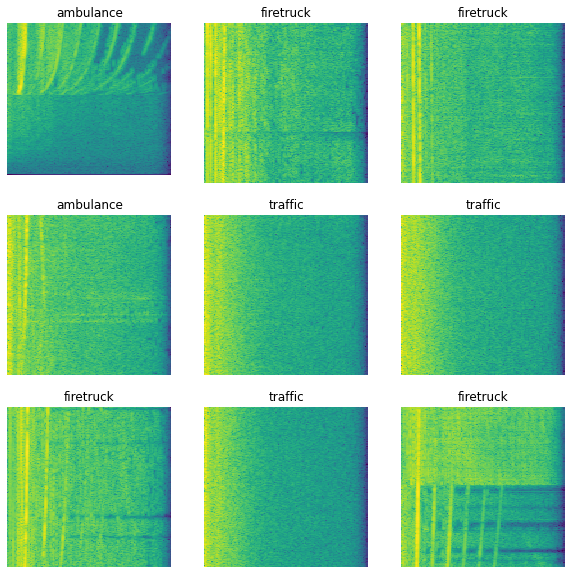

In [31]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram)
  height = log_spec.shape[0]
  X = np.arange(OUTPUT_SR * DUR, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')

plt.show()

In [32]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds


train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [33]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [34]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(labels)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (171, 129, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)        

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [36]:
EPOCHS = 20
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
8/8 [==============================] - 2s 118ms/step - loss: 0.8907 - accuracy: 0.5428 - val_loss: 0.3584 - val_accuracy: 0.8167
Epoch 2/20
8/8 [==============================] - 0s 28ms/step - loss: 0.5119 - accuracy: 0.8020 - val_loss: 0.2469 - val_accuracy: 0.8833
Epoch 3/20
8/8 [==============================] - 0s 26ms/step - loss: 0.3910 - accuracy: 0.8606 - val_loss: 0.2195 - val_accuracy: 0.9000
Epoch 4/20
8/8 [==============================] - 0s 27ms/step - loss: 0.3274 - accuracy: 0.8750 - val_loss: 0.2023 - val_accuracy: 0.8667
Epoch 5/20
8/8 [==============================] - 0s 27ms/step - loss: 0.3772 - accuracy: 0.8568 - val_loss: 0.1927 - val_accuracy: 0.9167
Epoch 6/20
8/8 [==============================] - 0s 30ms/step - loss: 0.2581 - accuracy: 0.8977 - val_loss: 0.1400 - val_accuracy: 0.9667
Epoch 7/20
8/8 [==============================] - 0s 37ms/step - loss: 0.2184 - accuracy: 0.9237 - val_loss: 0.1095 - val_accuracy: 0.9500
Epoch 8/20
8/8 [==========

In [37]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [38]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
print(y_pred)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

[1 0 2 1 0 0 1 1 1 0 1 1 0 2 0 2 0 2 0 2 0 0 1 1 0 1 2 2 2 0 1 2 2 0 2 2 2
 1 1 1 0 2 2 1 0 1 1 1 0 1 2 2 2 2 1 0 2 2 2 2 2]
Test set accuracy: 92%


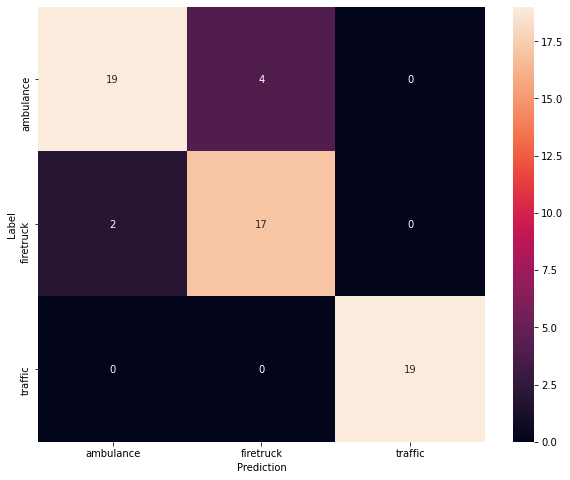

In [16]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [17]:
#uncomment This to save model

#model.save('model/v1')

INFO:tensorflow:Assets written to: model/v1\assets
